# 05 - Taming Text

## Deadline
Thursday December 15, 2016 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution
you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code

## Background
In this homework you will explore a relatively large corpus of emails released in public during the
[Hillary Clinton email controversy](https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy).
You can find the corpus in the `hillary-clinton-emails` directory of this repository, while more detailed information 
about the [schema is available here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

## Assignment
1. Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

2. Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. Aggregate 
the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level)
that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo
methods from the sentiment analysis module -- can you find substantial differences?

3. Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.

4. *BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.


# 0. Prelude

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Word cloud
Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

In [2]:
filename='hillary-clinton-emails/Emails.csv'
df = pd.read_csv(filename)
df.sample(5)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
1611,1612,C05761457,SUSAN BURK WAS JUST CONFIRMED.,H,"Mills, Cheryl D",32.0,2009-06-01T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/23_24_25_26/DO...,F-2014-20439,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>",NaN,"Monday, June 01, 2009 11:00 PM",F-2014-20439,C05761457,06/30/2015,RELEASE IN PART,Fyi,UNCLASSIFIED U.S. Department of State Case No....
6336,6337,C05771932,"H: MORE, MEMO #3 ON CAMPAIGN, WITH NEW POLL #S...",H,"Jiloty, Lauren",116.0,2010-09-06T04:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0096/DOC_0C0...,F-2014-20439,...,H,Lauren Jiloty < >,NaN,"Monday, September 6, 2010 11:18 PM",F-2014-20439,C05771932,08/31/2015,RELEASE IN PART,ok\n>,UNCLASSIFIED U.S. Department of State Case No....
4794,4795,C05768896,LETTER,H,"Valenzuela, Arturo A",12.0,2010-03-21T04:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0070/DOC_0C0...,F-2014-20439,...,H,"Valenzuela, Arturo A <ValenzuelaAA@state.gov>","Sullivan, Jacob J; Gonzalez, Juan S","Sunday, March 21, 2010 4:16 PM",F-2014-20439,C05768896,08/31/2015,RELEASE IN PART,NaN,UNCLASSIFIED U.S. Department of State Case No....
1009,1010,C05760219,DR.,JilotyLC@state.gov,H,80.0,2009-10-16T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/10_11_15_16/DO...,F-2014-20439,...,NaN,NaN,NaN,NaN,F-2014-20439,C05760219,06/30/2015,RELEASE IN PART,Pls print.,UNCLASSIFIED U.S. Department of State Case No....
467,468,C05758723,CABINET MTG,ValmoroLJ@state.gov,hrod17@clintonemail.com,80.0,2009-06-08T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/2_3_4/DOC_0C05...,F-2014-20439,...,'ValmoroU@state.gov'; Huma Abedin,H <hrod17@clintonemail.com>,NaN,"Monday, June 8, 2009 5:53 AM",F-2014-20439,C05758723,06/30/2015,RELEASE IN FULL,I heard on the radio that there is a Cabinet m...,UNCLASSIFIED U.S. Department of State Case No....


Let's extract the whole corpus by concatenating the subject and body of every e-mail:

In [3]:
def extract_corpus(df):
    raw_body    = df['ExtractedBodyText'].dropna().reset_index()
    raw_subject = df['ExtractedSubject'].dropna().reset_index()
    return ' '.join(raw_subject['ExtractedSubject']) + ' '.join(raw_body['ExtractedBodyText'])

raw_corpus = extract_corpus(df)

Define a helper function to generate a WordCloud:

In [4]:
def gen_wordcloud(text):
    wc = WordCloud(
        background_color='white',
        max_font_size=50
    )
    
    return wc.generate(text)

Define a helper function to plot a WordCloud:

In [5]:
from wordcloud import WordCloud

def plot_wordcloud(cloud, figsize=(16, 12)):
    plt.figure(figsize=figsize)
    plt.imshow(cloud)
    plt.axis("off")
    plt.show()

### 1.1 No pre-processing

Here, we plot a WorldClout of the raw corpus, before any type of pre-processing (such as stemming, etc.):

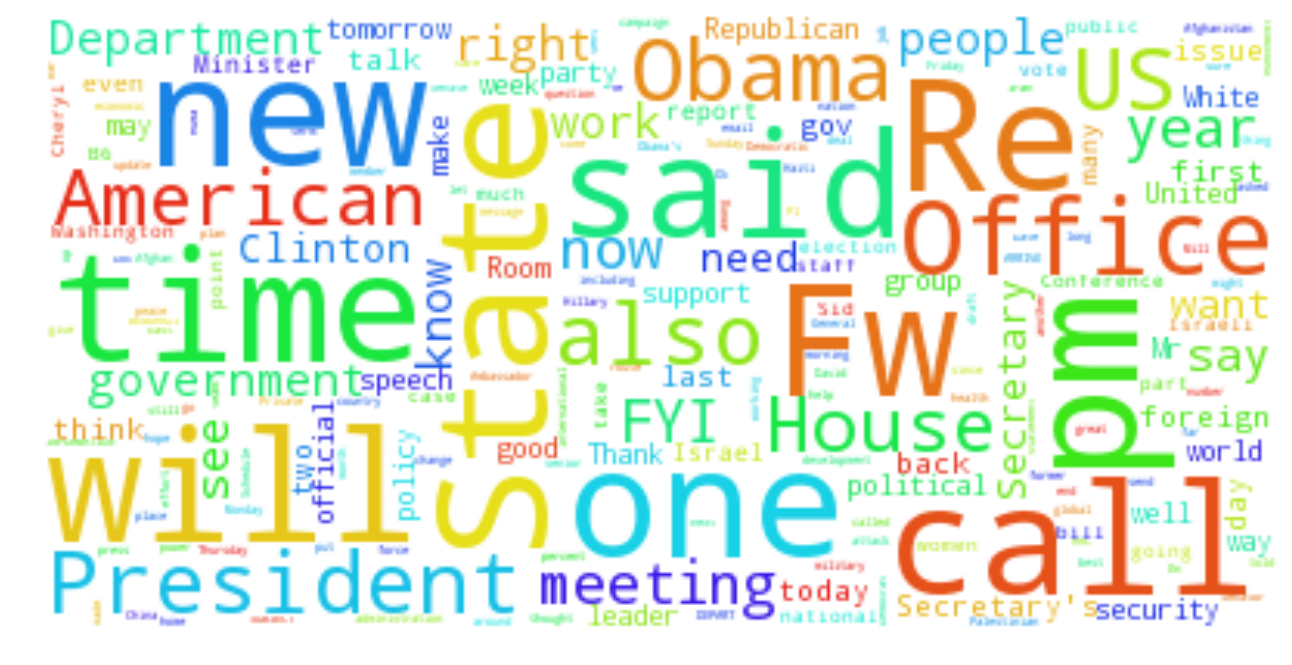

In [6]:
wordcloud = gen_wordcloud(raw_corpus)
plot_wordcloud(wordcloud)

### 1.2 Standard stemming

For this part we will use `ntlk`'s built-in Snowball stemmer and tokenizer, plus a list of custom stopwords.

In [7]:
from nltk.stem.snowball import SnowballStemmer

english_stopwords = nltk.corpus.stopwords.words('english')

local_stopwords = [
    'fyi', 'will', 'call', 'said', 'time', 'want', 'know', 'pm', 'am', 
    'also', 'call', 'know', 'would', 'get', 'time', 'work', 'like', 'today',
    'see', 'morning', 'also', 'back', 'tomorrow', 'meeting', 'think', 'good',
    'want', 'could', 'working', 'well', 'pls', 're', 'fw', 'new', 'thx', 'fwd'
]

stopwords = set(english_stopwords + local_stopwords)

stemmer = SnowballStemmer('english', ignore_stopwords=True)

Let's define a helper function to tokenize and stem some text:

In [8]:
import re

def tokenize_and_stem(text):
    
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = [token for token in tokens if re.search('^[a-zA-Z]+$', token)]

    # Stem the resulting tokens, filtering out words present in our local stopwords list
    stems = [stemmer.stem(token) for token in filtered_tokens if token not in stopwords]
    
    # Once again, filter out words present in our local stopwords list
    return [stem for stem in stems if stem not in stopwords and len(stem) > 1]

Tokenize the whole corpus:

In [9]:
tokenized = tokenize_and_stem(raw_corpus)

Join the list of tokens by space, to get a single resulting string:

In [10]:
flat_tok = ' '.join(tokenized)

Generate and plot a WordCloud of that resulting string:

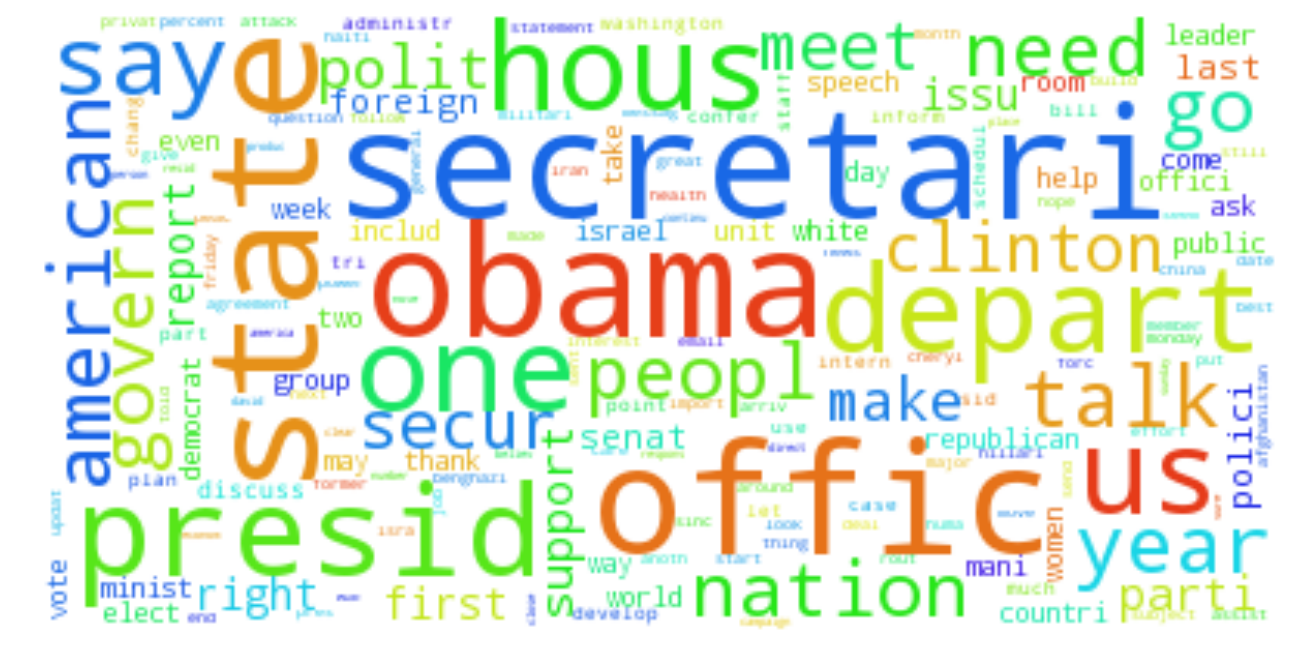

In [11]:
wordcloud_processed = gen_wordcloud(flat_tok)
plot_wordcloud(wordcloud_processed)

It's clear that the latter Wordcloud is both more interesting and more informative than the first one, as it doesn't feature common words, and only focus on stemmed words. For example, it features prominenty the stemmed word `secreatari`, which only appear very small as `Secretary's` in the raw WordCloud.

# 2. Sentiment analysis

* Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
* Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. 
* Aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries.
* Repeat the aggregation + plotting steps using different demo methods from the sentiment analysis module -- can you find substantial differences?

### Extract countries and perform sentiment analysis

Please see [extract_countries_parallel.py](https://github.com/romac/ADAHomeworks/blob/master/05%20-%20Taming%20Text/extract_countries_parallel.py) for the code we used to process the whole corpus of e-mails in parallel and generate the following two pickled data structures:

In [12]:
import pickle

sentiments_data_nocodes = pickle.load(open('countries_sentiments_vader_nocodes.p', 'rb'))
sentiments_data_codes   = pickle.load(open('countries_sentiments_vader_codes.p', 'rb'))

### Aggregate the polarity information of all the emails by country,

In [13]:
def aggregate_by_country(data, threshold):
    res = {}

    for key in data:
        sents = data[key]['sentiments']
        count = data[key]['count']

        if count < threshold:
            continue

        res[key] = {
            'sentiment': sum(sents) / float(len(sents)),
            'count': count
        }

    countries_df = pd.DataFrame.from_dict(res, orient='index')
    countries_df = countries_df.sort_values(by='sentiment', axis=0)
    
    return countries_df

In [14]:
countries_df_nocodes = aggregate_by_country(sentiments_data_nocodes, 25)
countries_df_codes = aggregate_by_country(sentiments_data_codes, 500)

### Plot a histogram that summarizes the perception of the different countries

In [15]:
def plot_countries(countries_df):

    # Credits to Stack Overflow :
    # http://stackoverflow.com/questions/31313606/pyplot-matplotlib-bar-chart-with-fill-color-depending-on-value
    from matplotlib import cm

    plt.figure(figsize=(18, 8), dpi=80)

    # Set up colors : red to green
    y = np.array(countries_df['sentiment'])
    colors = cm.RdYlGn((y / float(max(y))))
    plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
    plt.clf()
    clb = plt.colorbar(plot)
    clb.ax.set_title("Sentiment")

    # Display bar plot : country frequency vs. country name, with color indicating polarity score
    plt.bar(range(countries_df.shape[0]), countries_df['count'], align='center', tick_label=countries_df.index, color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Country")
    plt.ylabel("Frequency")
    plt.show()

#### When using only the country names to match countries in the corpus

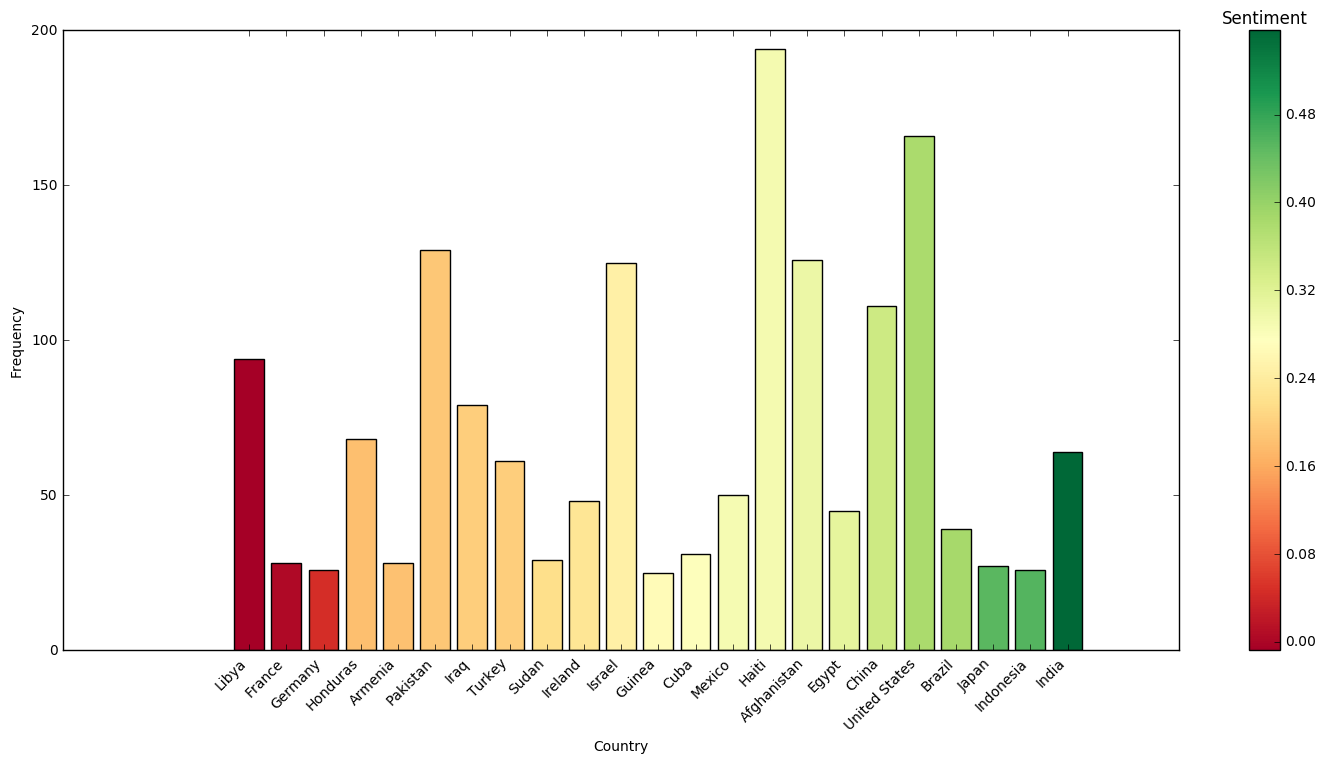

In [16]:
plot_countries(countries_df_nocodes)

#### When using the country names and short codes to match countries in the corpus

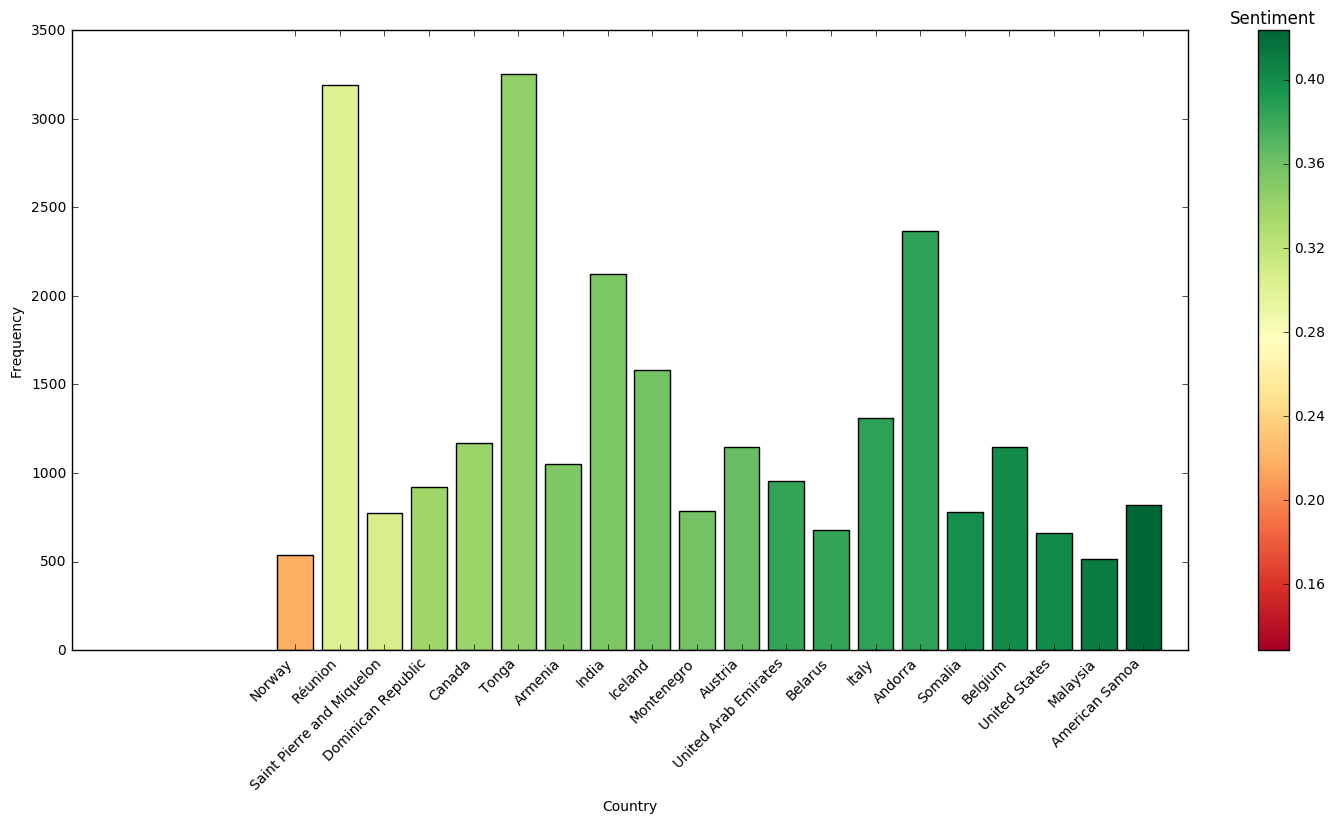

In [17]:
plot_countries(countries_df_codes)

**Note:** We weren't able to get the Liu-Hu sentiment analysis method to run over the whole dataset in a reasonable time, and thus chose to stick with the Vader method which, after some tests over a sample of the data, appears to us to be more accurate. Hence, we chose to try a couple different methods for country extraction: one where we take the countries' names and short codes into account, and one where we only use the short and offical names. The results are quite different, as the number of matched countries when using the shortcodes is much greater. We're not very confident that the results we get are very accurate using the short codes, since it's very unlikely that people would refer to eg. Montenegro or Malaysia by their short codes in an e-mail. We nonetheless chose to keep the latter plot, as a comparison point.

# 3. Topic modelling 

In this section we will try to model the different topics mentionned in the e-mail corpus. The method used here is Latent Dirichlet Analysis (LDA). We wanted to compare the scikit-learn version with the (recommended) gensim version, so here they are both :)

### 3.1 Sci-kit learn version

In [18]:
# Import all the things
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.externals import joblib

Let's define some helper methods that will compute the Term Frequency (`*_tf`) and Index Frequency (`*_tfidf`), as well as run the LDA model for us. Both will stem and tokenize the text for it to be consumed by the LDA.

In [19]:
def fit_tfidf(emails):
    """
    Takes emails as an array of str and returns a Term Frequency / Index Frequency vectorized array of the corpus.
    """
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                       min_df=0.2, stop_words=text.ENGLISH_STOP_WORDS,
                                       use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(emails)
    terms = tfidf_vectorizer.get_feature_names()
    return (terms, tfidf_matrix, tfidf_vectorizer)

In [20]:
def fit_tf(emails):
    """
    Takes emails as an array of str and returns a Term Frequency (i.e. a Count Vectorizer) vectorized array of the corpus.
    """
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=1000,
                                    stop_words=text.ENGLISH_STOP_WORDS)
    tf_matrix = tf_vectorizer.fit_transform(emails)
    terms = tf_vectorizer.get_feature_names()
    return (terms, tf_matrix, tf_vectorizer)

In [21]:
def run_lda(tf_matrix, tf_vectorizer):
    """
    Fits the LDA model to the vectorized corpus.
    """
    lda = LatentDirichletAllocation(n_topics=n_topics,
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf_matrix)
    return lda

In [22]:
def print_top_words(model, feature_names, n_top_words=20):
    """
    A helper to print the main topics from the computed LDA model.
    """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join(['\n + ' + str(topic[i]) + '*' + str(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Our helpers are ready we can now vectorize and then run the model !

In [23]:
tfidf_terms, tfidf_matrix, tfidf_vectorizer = fit_tf(df['ExtractedBodyText'].dropna())

In [24]:
# No need to recompute everything, let's save to a pickle

#joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')
#joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
#joblib.dump(tfidf_terms, 'tfidf_terms.pkl')

In [25]:
n_topics = 10; n_top_words = 20

In [26]:
lda = run_lda(tfidf_matrix, tfidf_vectorizer)

In [27]:
#joblib.dump(lda, 'sklearn_lda_model.pkl')

Of course visualization is important so let's take inspiration from part 1 and build word clouds for the main computed topics.

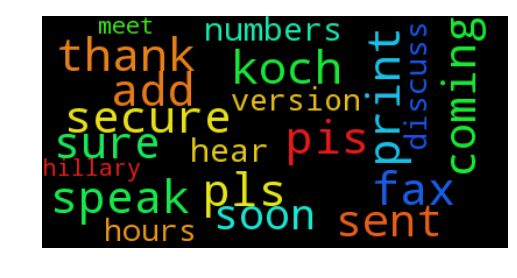

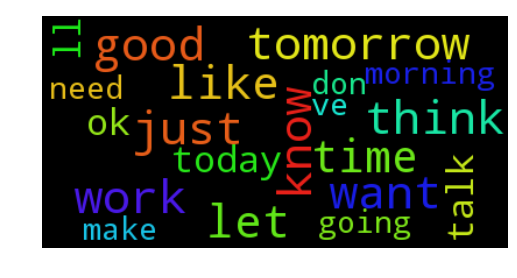

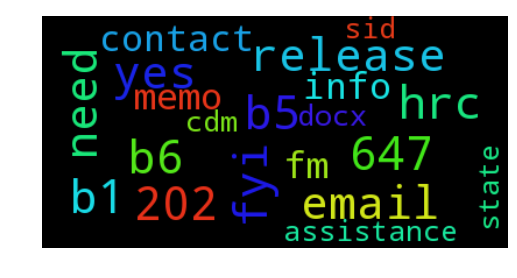

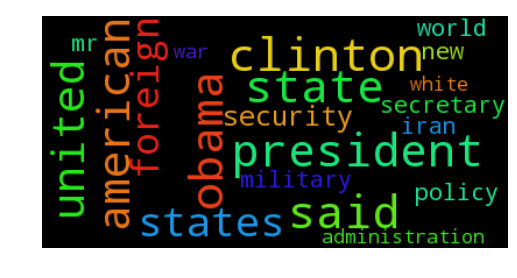

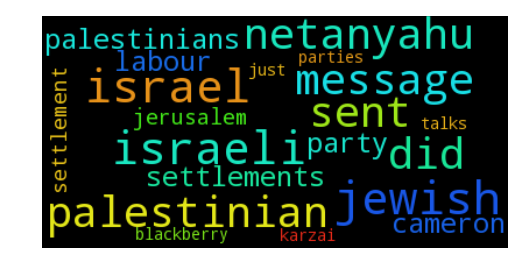

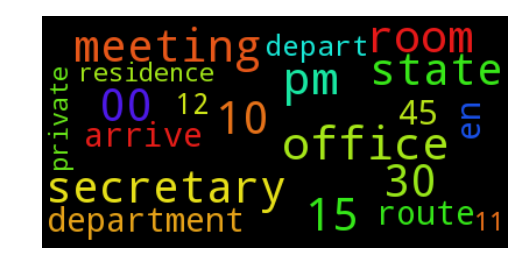

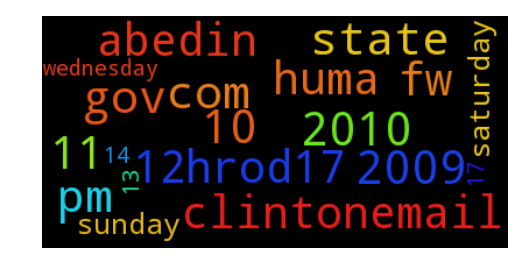

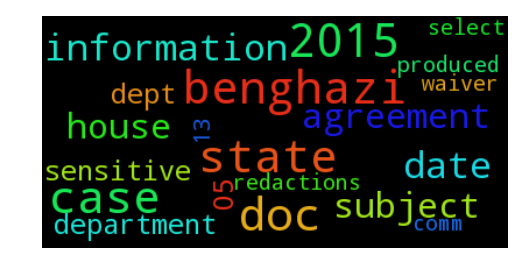

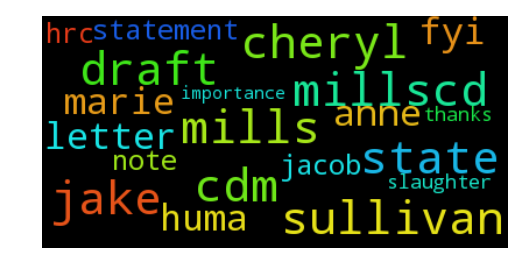

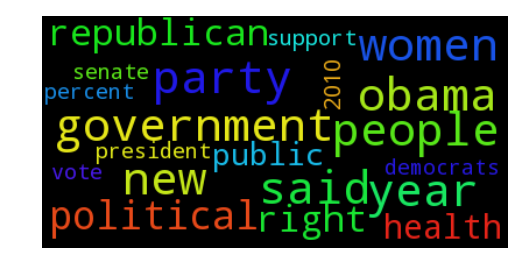

In [28]:
def print_wordclouds(model, feature_names, n_top_words=20):
    for _, topic in enumerate(model.components_):
        freqs = [(str(feature_names[i]), topic[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]
        cloud = WordCloud(max_font_size=40).fit_words(freqs)
        plot_wordcloud(cloud, figsize=None)
        
print_wordclouds(lda, tfidf_terms, n_top_words)

We can also check out the weights of the words found for each topic, with a simple print :

In [29]:
print_top_words(lda, tfidf_terms, n_top_words)

Topic #0:

 + 256.296004302*pls 
 + 238.633932215*print 
 + 178.356853464*thank 
 + 153.938180524*koch 
 + 127.77623719*pis 
 + 86.6047152067*add 
 + 70.4246712501*fax 
 + 69.7582445507*secure 
 + 68.5047329801*speak 
 + 39.8028888905*coming 
 + 39.4749971608*sure 
 + 37.5250937124*sent 
 + 28.1236385637*soon 
 + 19.2837182355*numbers 
 + 15.3064306839*hear 
 + 10.8432831735*version 
 + 8.60784517733*discuss 
 + 8.03640413908*hours 
 + 8.02951418101*hillary 
 + 6.3255957563*meet
Topic #1:

 + 656.982975215*know 
 + 558.153659417*just 
 + 480.041426977*think 
 + 435.22715219*want 
 + 425.617145753*work 
 + 413.000579285*tomorrow 
 + 400.337322627*good 
 + 394.352757896*like 
 + 385.753198842*let 
 + 377.762436724*time 
 + 371.788236429*today 
 + 339.525340384*talk 
 + 311.485375768*ll 
 + 303.332387665*ok 
 + 291.038663525*going 
 + 286.980379793*don 
 + 256.240536066*make 
 + 227.562769691*need 
 + 227.513572332*morning 
 + 226.713983979*ve
Topic #2:

 + 682.589549869*fyi 
 + 318.40856

### 3.2 gensim version

In [30]:
# Import some more stuff
import gensim
import joblib
from gensim import corpora, models
import pyLDAvis.gensim

load_from_disk = True

if not load_from_disk:

    texts = []

    mail_df = df[['ExtractedSubject', 'ExtractedBodyText']].dropna()

    for idx, mail in mail_df.iterrows():
        text = str(mail['ExtractedSubject']) + ' ' + str(mail['ExtractedBodyText'])
        tokens = tokenize_and_stem(text)
        texts.append(tokens)

    # Create dictionary
    dictionary = corpora.Dictionary(texts)

    # Bag of Words
    corpus = [dictionary.doc2bow(text) for text in texts]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=3)
    
    # joblib.dump(ldamodel, 'gensim_lda_model.pkl')
    
else:
    
    # Load the data we computed in the previous run
    ldamodel = joblib.load('gensim_lda_model.pkl')

/Users/Dylan/anaconda/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
/Users/Dylan/anaconda/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/Users/Dylan/anaconda/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/Users/Dylan/anaconda/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/Users/Dylan/anaconda/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = i

In [31]:
# Simple print for debug purposes
topics = ldamodel.show_topics(num_topics=15, num_words=10, formatted=False)
topics

[(0,
  [('speech', 0.02028582936731594),
   ('draft', 0.020021295638960098),
   ('ok', 0.019820589919848995),
   ('list', 0.016727283553755256),
   ('pis', 0.011729403589186373),
   ('go', 0.011608904789016926),
   ('send', 0.011378277747779445),
   ('talk', 0.010919800801504639),
   ('print', 0.010503284678188791),
   ('ask', 0.010502066153028794)]),
 (1,
  [('vote', 0.022800995615787172),
   ('favor', 0.01897913828886371),
   ('enough', 0.015842224047304603),
   ('unfavor', 0.015099125104603719),
   ('percent', 0.014987837996477875),
   ('elect', 0.01131934083631898),
   ('obama', 0.010520561431189025),
   ('vol', 0.0096105745437041062),
   ('opinion', 0.0092202397977124775),
   ('refus', 0.0090129256347928014)]),
 (2,
  [('hrc', 0.012383187894225101),
   ('print', 0.0085933095207822319),
   ('minist', 0.0085446636368858714),
   ('women', 0.0072071384360514884),
   ('meet', 0.006221040432216403),
   ('foreign', 0.0060611030797036039),
   ('gender', 0.0060099059159216348),
   ('gore',

We can do some even cooler visualisations thanks to the [pyLDAvis package](https://github.com/bmabey/pyLDAvis). It will graph the LDA model generated by `gensim`, and will allow for some more interactive inspection of the model.

In [32]:
pyldavis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(pyldavis)

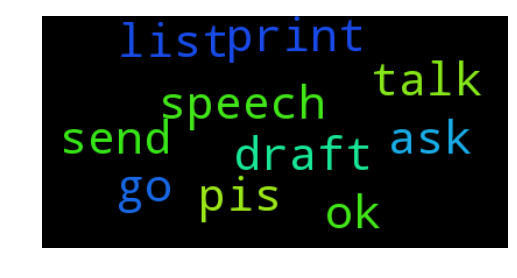

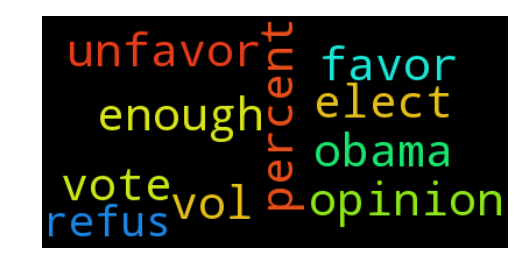

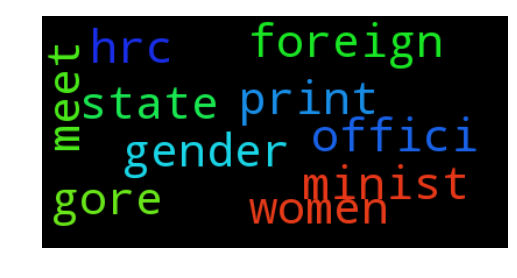

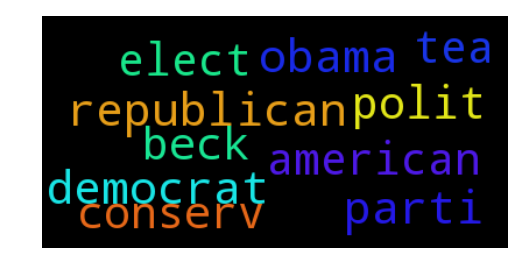

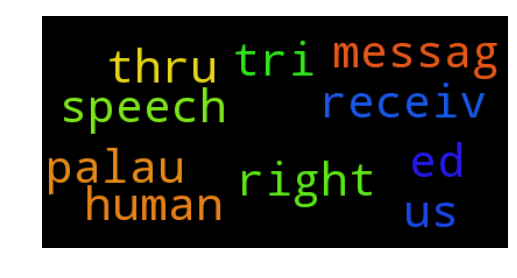

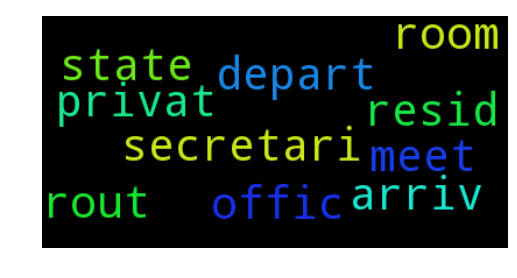

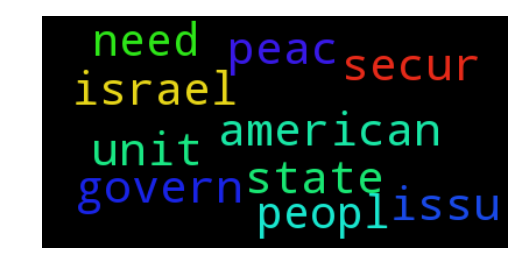

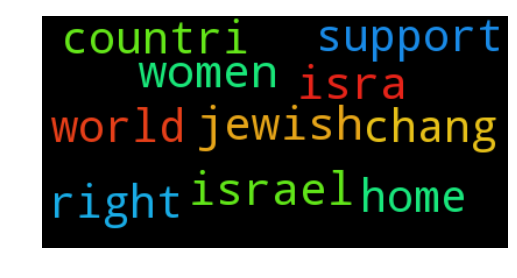

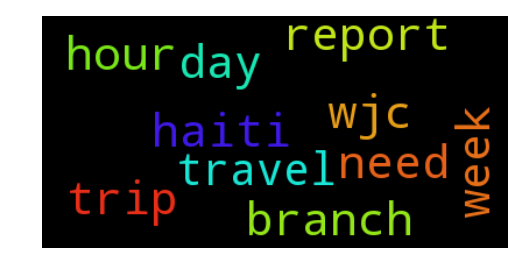

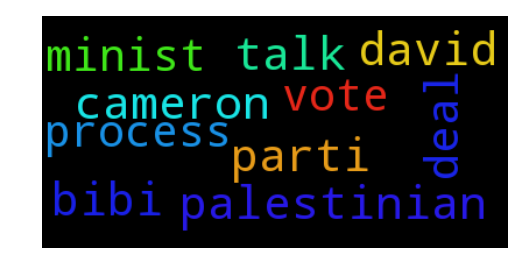

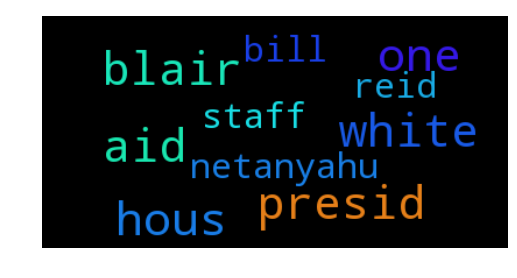

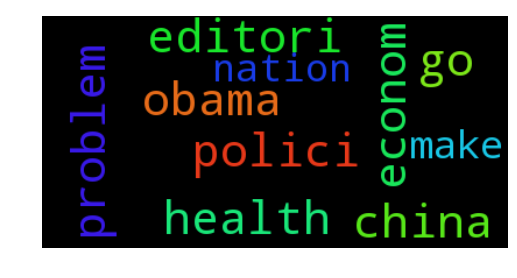

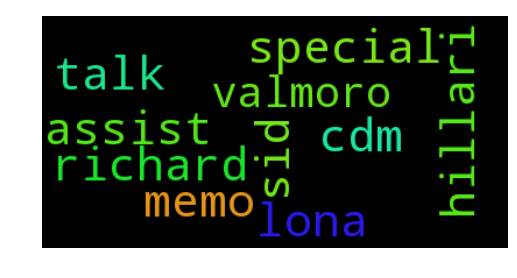

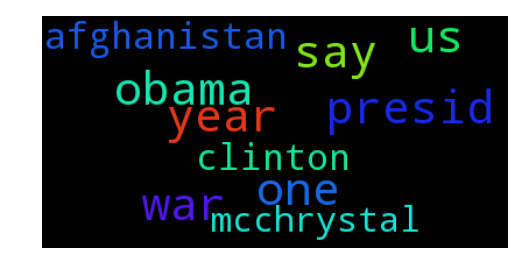

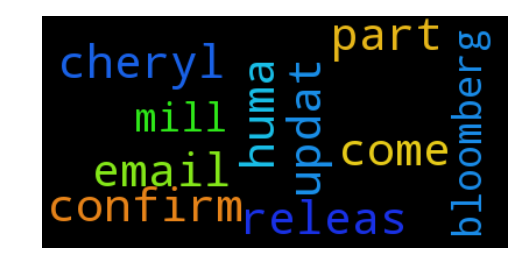

In [33]:
# Let's also add another word cloud for consistency
for (_, terms) in topics:
    cloud = WordCloud(max_font_size=40).fit_words(terms)
    plot_wordcloud(cloud, figsize=None)

# 4. (bonus) Communication graph
*BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.

In [34]:
import pandas as pd
import networkx as nx
import community

In [35]:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
aliases_dict = pd.read_csv('hillary-clinton-emails/Aliases.csv').to_dict('records')
persons_dict = pd.read_csv('hillary-clinton-emails/Persons.csv').to_dict('records')

In [36]:
aliases = {}

for alias_dict in aliases_dict:
    aliases[alias_dict['Alias']] = alias_dict['PersonId']

In [37]:
persons = {}

for person_dict in persons_dict:
    persons[person_dict['Id']] = person_dict['Name']

In [38]:
def get_name(raw):
    # Sanitization of the name taken from
    # https://www.kaggle.com/beautifuldataviz/d/kaggle/hillary-clinton-emails/clinton-email-graph-d3-js
    alias = str(raw).lower().replace(',', '').split('@')[0]
    if alias in aliases:
        return persons[aliases[alias]]
    else:
        return '???'

In [39]:
emails['From'] = emails['MetadataFrom'].apply(get_name)
emails['To'] = emails['MetadataTo'].apply(get_name)

In [40]:
res = [
    ((str(row['From']), str(row['To'])), str(row['ExtractedBodyText']))
    for _, row in emails.iterrows()
]

In [41]:
edges = [edge for (edge, _) in res]

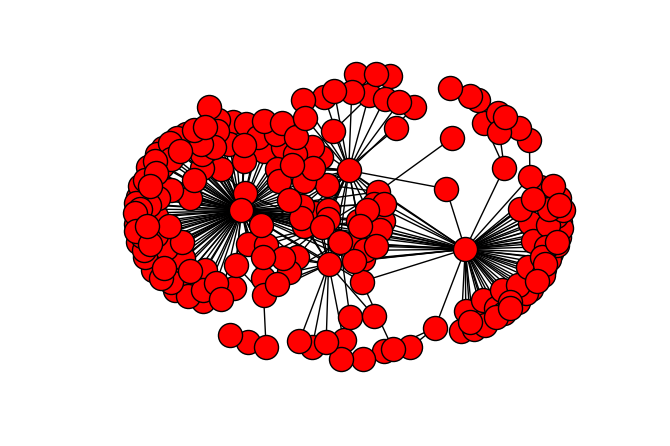

In [42]:
graph = nx.Graph()
graph.add_edges_from(edges)
nx.draw(graph, pos=nx.spring_layout(graph))

In [43]:
communities = community.best_partition(graph)

In [44]:
text_by_community = {}

for ((f, t), m) in res:
    if f not in communities:
        continue
        
    c = communities[f]
    
    if c not in text_by_community:
        text_by_community[c] = ''
        
    text_by_community[c] += m

In [45]:
for c in text_by_community:
    text_by_community[c] = tokenize_and_stem(text_by_community[c])

In [46]:
freqs = {}

for c in text_by_community:
    freqs[c] = {}
    
    for word in text_by_community[c]:
        if word not in freqs[c]:
            freqs[c][word] = 0
            
        freqs[c][word] += 1

In [47]:
for c in freqs:
    words = list(freqs[c].items())
    sorted_words = sorted(words, key=lambda x: x[1], reverse=True)
    print('# Community #{}'.format(c))
    text = '\n'.join([w for (w, _) in sorted_words[0:20]])
    print(text)

# Community #0
women
state
go
talk
thank
need
us
let
one
make
year
depart
issu
ask
come
secretari
best
meet
way
hope
# Community #1
state
need
depart
make
polici
us
one
nation
govern
go
american
secur
support
world
offic
peopl
inform
way
foreign
year
# Community #2
state
secretari
offic
obama
presid
depart
one
american
hous
parti
say
polit
year
republican
democrat
nation
meet
govern
senat
us
# Community #3
nan
# Community #4
nan
# Community #5
state
hous
presid
depart
clinton
govern
us
one
peopl
secretari
secur
inform
benghazi
unit
agreement
case
say
issu
obama
nation
# Community #6
nannan
# Community #7
nannannannannan
# Community #8
nannannan
# Community #9
nan
# Community #10
nannannannannannan
# Community #11
richard
say
year
women
state
one
place
peopl
first
depart
fisa
vote
day
citi
secretari
candid
director
life
jamal
book
# Community #12
settlement
un
peopl
haitian
govern
need
ingo
plan
latrin
though
one
local
includ
au
princ
committe
least
port
secur
help
# Community #13
day
s